In [2]:
# Imports
import os, sys, json, time
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, models

print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.20.0
GPUs: []


In [3]:
# Helper to fetch NASA POWER hourly data for a lat/lon
def fetch_power_point(lat, lon, start_date, end_date,
                      params="T2M,RH2M,ALLSKY_SFC_SW_DWN"):
    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    payload = {
        "start": start_date.strftime("%Y%m%d"),
        "end": end_date.strftime("%Y%m%d"),
        "latitude": lat,
        "longitude": lon,
        "parameters": params,
        "community": "RE",
        "format": "JSON"
    }

    r = requests.get(url, params=payload, timeout=60)
    r.raise_for_status()
    data = r.json()

    ts = data.get('properties', {}).get('parameter', {})
    if not ts:
        raise ValueError("No data returned from NASA POWER API.")

    example_param = next(iter(ts))
    times = sorted(ts[example_param].keys())

    rows = []
    for t in times:
        row = {"timestamp_utc": pd.to_datetime(t, format="%Y%m%d%H")}
        for param in ts:
            row[param] = ts[param].get(t, np.nan)
        rows.append(row)

    df = pd.DataFrame(rows).set_index('timestamp_utc').sort_index()
    return df

# Fetch for New Delhi (last 30 days)
start = datetime.utcnow().date() - timedelta(days=30)
end = datetime.utcnow().date()

df_power = fetch_power_point(28.6139, 77.2090, start, end)
df_power.head()


C:\Users\rashi\AppData\Local\Temp\ipykernel_22740\3646049719.py:37: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start = datetime.utcnow().date() - timedelta(days=30)
C:\Users\rashi\AppData\Local\Temp\ipykernel_22740\3646049719.py:38: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end = datetime.utcnow().date()


,T2M,RH2M,ALLSKY_SFC_SW_DWN
timestamp_utc,,,
2025-08-18 00:00:00,27.29,94.28,-999.0
2025-08-18 01:00:00,27.02,94.62,-999.0
2025-08-18 02:00:00,26.76,95.50,-999.0
2025-08-18 03:00:00,26.50,96.64,-999.0
2025-08-18 04:00:00,26.28,97.56,-999.0


In [4]:
# Mock CPCB AQI/PM2.5 data (replace with actual CPCB CSV/endpoint)
cpcb_df = pd.DataFrame({
    "timestamp_utc": pd.date_range(start=start, periods=24*30, freq='h'),
    "station_id": ["DEL_STN_1"] * (24*30),
    "pm25": np.random.normal(80, 20, 24*30)
}).set_index("timestamp_utc")

cpcb_df.head()


,station_id,pm25
timestamp_utc,,
2025-08-18 00:00:00,DEL_STN_1,107.241657
2025-08-18 01:00:00,DEL_STN_1,109.277262
2025-08-18 02:00:00,DEL_STN_1,105.608001
2025-08-18 03:00:00,DEL_STN_1,70.332180
2025-08-18 04:00:00,DEL_STN_1,110.262154


In [5]:
# Join POWER weather data and CPCB PM2.5
df = df_power.join(cpcb_df, how='left')
df = df.resample('h').median(numeric_only=True)
df[['T2M', 'RH2M', 'ALLSKY_SFC_SW_DWN', 'pm25']].head()


,T2M,RH2M,ALLSKY_SFC_SW_DWN,pm25
timestamp_utc,,,,
2025-08-18 00:00:00,27.29,94.28,-999.0,107.241657
2025-08-18 01:00:00,27.02,94.62,-999.0,109.277262
2025-08-18 02:00:00,26.76,95.50,-999.0,105.608001
2025-08-18 03:00:00,26.50,96.64,-999.0,70.332180
2025-08-18 04:00:00,26.28,97.56,-999.0,110.262154


In [6]:
from sklearn.preprocessing import StandardScaler

# Ensure datetime index & numeric PM2.5
df.index = pd.to_datetime(df.index)
df['pm25'] = pd.to_numeric(df['pm25'], errors='coerce')
df = df.dropna(subset=['pm25'])

# Time features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

# Lag features
for lag in [1, 2, 3]:
    df[f'pm25_lag_{lag}'] = df['pm25'].shift(lag)

# Rolling stats
df['pm25_roll_mean_3h'] = df['pm25'].rolling(3).mean()
df['pm25_roll_std_3h'] = df['pm25'].rolling(3).std()

df = df.dropna()

# Scale features
features = df.drop(columns=['pm25'])
scaler = StandardScaler()
df[features.columns] = scaler.fit_transform(features)

print("Final features:", df.columns.tolist())
df.head()


Final features: ['T2M', 'RH2M', 'ALLSKY_SFC_SW_DWN', 'pm25', 'hour', 'dayofweek', 'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'pm25_roll_mean_3h', 'pm25_roll_std_3h']


,T2M,RH2M,ALLSKY_SFC_SW_DWN,pm25,hour,dayofweek,pm25_lag_1,pm25_lag_2,pm25_lag_3,pm25_roll_mean_3h,pm25_roll_std_3h
timestamp_utc,,,,,,,,,,,
2025-08-18 03:00:00,0.261197,0.310043,0.0,70.332180,-1.237717,-1.401303,1.241523,1.417861,1.316680,1.291809,0.337693
2025-08-18 04:00:00,0.260340,0.313436,0.0,110.262154,-1.092852,-1.401303,-0.494186,1.237568,1.416649,1.320671,0.372122
2025-08-18 05:00:00,0.259678,0.315906,0.0,83.015685,-0.947987,-1.401303,1.470526,-0.495746,1.236452,0.658618,0.222883
2025-08-18 06:00:00,0.261469,0.311149,0.0,85.697401,-0.803122,-1.401303,0.129892,1.466254,-0.495943,1.108886,-0.338604
2025-08-18 07:00:00,0.266611,0.290722,0.0,90.931125,-0.658257,-1.401303,0.261843,0.127471,1.465017,0.542402,-1.484354


In [7]:
# Train/test split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train, y_train = train.drop(columns=['pm25']), train['pm25']
X_test, y_test = test.drop(columns=['pm25']), test['pm25']

# Model: RandomForest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
pred = rf.predict(X_test)

print("Sample predictions:", pred[:10])   # show first 10 predictions
print("Actual values:", y_test.head(10).tolist())
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)

print("RMSE:", rmse)
print("MAE:", mae)


Sample predictions: [88.3174727  86.03368311 93.5932288  83.96894062 52.33211726 88.23011653
 56.8190741  87.6704165  78.27151736 84.2522292 ]
Actual values: [92.48621533588572, 81.34737274463376, 97.9295308114848, 77.79662481623905, 50.13438708613487, 93.54412405880426, 47.5919230692555, 98.84479043030714, 78.81466143374408, 91.87210748994771]
RMSE: 6.436543534749677
MAE: 4.913214750941474


In [8]:
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)

print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 6.436543534749677
MAE: 4.913214750941474


RMSE: 6.436543534749677
MAE: 4.913214750941474


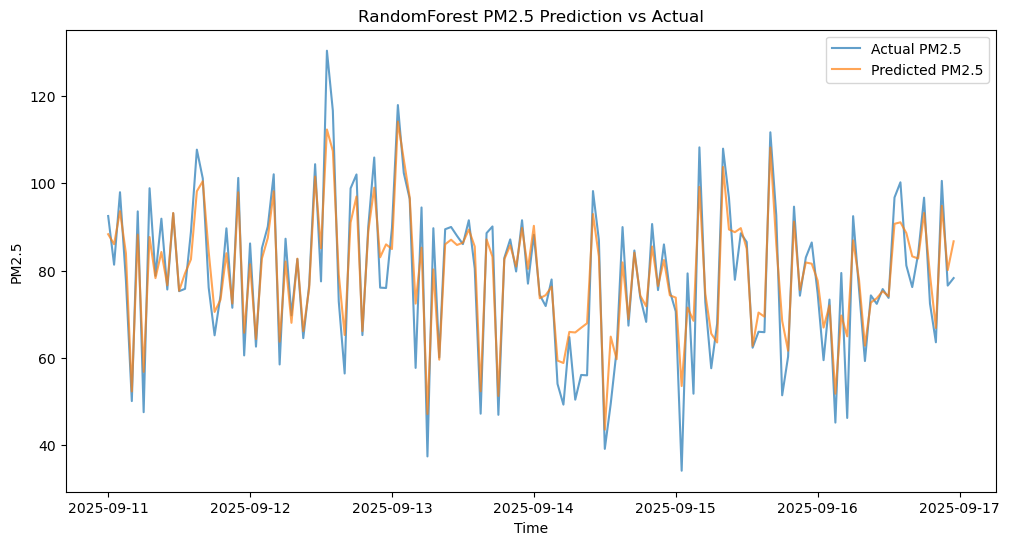

In [9]:
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)

print("RMSE:", rmse)
print("MAE:", mae)

# Plot predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label="Actual PM2.5", alpha=0.7)
plt.plot(y_test.index, pred, label="Predicted PM2.5", alpha=0.7)
plt.legend()
plt.title("RandomForest PM2.5 Prediction vs Actual")
plt.ylabel("PM2.5")
plt.xlabel("Time")
plt.show()


In [10]:
# Cell: AQI alert for users
import pandas as pd

# Use your PM2.5 series from the graph
# Example: df['pm25'] is what you plotted
pm25_series = df['pm25']  # replace with your series if different

# CPCB thresholds
thresholds = {
    "Good": (0, 30),
    "Satisfactory": (31, 60),
    "Moderately Polluted": (61, 90),
    "Poor": (91, 120),
    "Very Poor": (121, 250),
    "Severe": (251, float('inf'))
}

# Check latest value (or you can loop through series)
latest_value = pm25_series.iloc[-1]

# Determine AQI category
category = None
for cat, (low, high) in thresholds.items():
    if low <= latest_value <= high:
        category = cat
        break

# Print alert
print(f"Latest PM2.5 value: {latest_value:.1f} µg/m³")
print(f"Air Quality Category: {category}")

if category in ["Poor", "Very Poor", "Severe"]:
    print("⚠️ WARNING: Air quality is unhealthy. Sensitive groups should take precautions!")
elif category == "Moderately Polluted":
    print("⚠️ CAUTION: Air quality is moderate. Consider limiting prolonged outdoor exertion.")
else:
    print("Air quality is safe for general population.")


Latest PM2.5 value: 78.3 µg/m³
Air Quality Category: Moderately Polluted
⚠️ CAUTION: Air quality is moderate. Consider limiting prolonged outdoor exertion.
